# L8 exercise

Below is the 'nearly' complete FWI algorithm - only the value of $\alpha$ is missing.

1. Find the range of values of $\alpha$ for which the algorithm shows reasonable convergence. What appears to be roughly the optimal value?
2. Change the source and receiver locations. How do different acquisition geometries affect the results? (Note that you may also need to extend the simulation time for certain geometries).
3. Play around with some other buttons (source and receiver numbers, boundary layer width, space order or the wave-field etc.) to see how these changes impact the quality of the final image.

In [91]:
! pip install devito

In [92]:
!git clone https://github.com/matt-piggott/Geophysical-inversion-undergraduate.git

fatal: destination path 'Geophysical-inversion-undergraduate' already exists and is not an empty directory.


In [93]:
# This cell contains the various imports we will need

import numpy as np
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt

from devito import TimeFunction, Operator, Eq, solve, Function
from devito import norm, mmax, mmin
from examples.seismic import AcquisitionGeometry, Receiver
from examples.seismic.model import Model
from examples.seismic.acoustic import AcousticWaveSolver

from devito import configuration
configuration['log-level'] = 'WARNING'

### Load a subset of the Marmousi velocity model

We choose our $v_p$ model to have a size of 401x201 (instead of the full 1601x401 contained in the original data file) to save computational cost. We smooth the original/true model $v_p$ and save the smoothed model in `model0` as an initial velocity model for FWI. We also set the model spacing to be `dx=dz=10m`, with origin `x0=z0=0`, and padding boundary `nbl=10`. The plots below shows true & smooth models, and their difference.

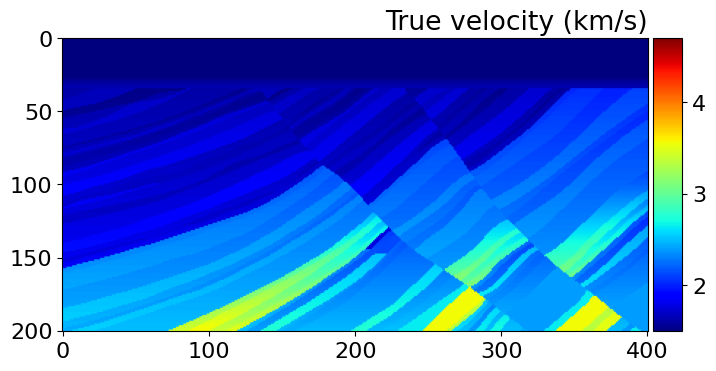

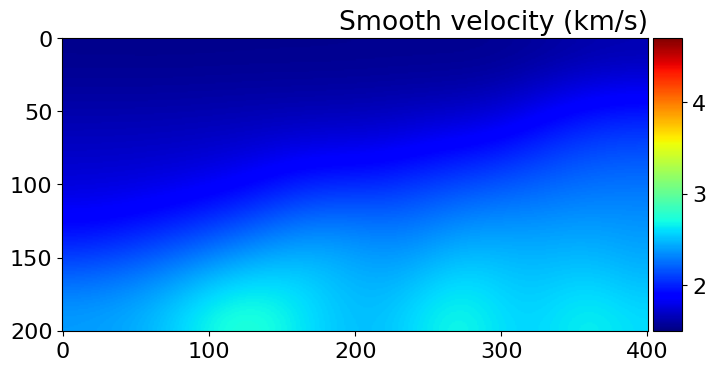

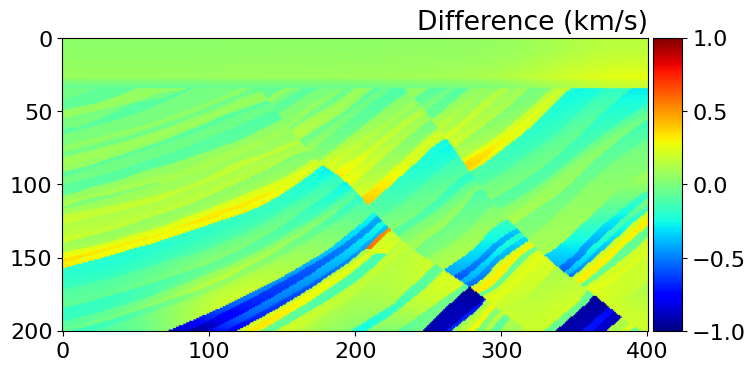

In [94]:
#Load 2D Marmousi velocity model, update the path of 'vp_marmousi_bi' as needed
v = np.fromfile('/content/Geophysical-inversion-undergraduate/lectures/L8/exercise/vp_marmousi_bi', dtype='float32', sep="")

#Velocity model dimension
shape = (1601, 401)
spacing = (10., 10.)
origin = (0., 0.)
nbl = 10
v = v.reshape(shape)

#Cut velocity model size from (1601,401) to (401,201)
v = v[600:-600, :201]

# Gaussian smoothing of the true velocity model
v_sm = gaussian_filter(v, sigma=(30, 30), order=0)

#True Vp model
model = Model(vp=v, space_order=4, dtype=np.float32, nbl=nbl, grid=None,
              shape=v.shape, origin=origin, spacing=spacing, bcs="damp")

#Smooth/Initial Vp model
model0 = Model(vp=v_sm, space_order=4, dtype=np.float32, nbl=nbl, grid=model.grid,
               shape=v.shape, origin=origin, spacing=spacing, bcs="damp")

#Plot true & smooth Vp models, and their difference
from examples.seismic import plot_image
plt.title('True velocity (km/s)', loc='right')
plot_image(v, vmin=1.5, vmax=4.7, cmap="jet")
plt.title('Smooth velocity (km/s)', loc='right')
plot_image(v_sm, vmin=1.5, vmax=4.7, cmap="jet")
plt.title('Difference (km/s)', loc='right')
plot_image(v_sm-v, vmin=-1.0, vmax=1.0, cmap="jet")

## Set up the acquisition geometry

In part 1, we will use 11 sources and 101 receivers that spread evenly across the whole horizontal dimension of the Vp model, at a depth of 20m. In the plot below, the top figure shows the acquisition geometry (red dot=source, green dot=receiver), overlaid with the True Vp model. The bottom figure shows the Ricker source wavelet used for this demo.

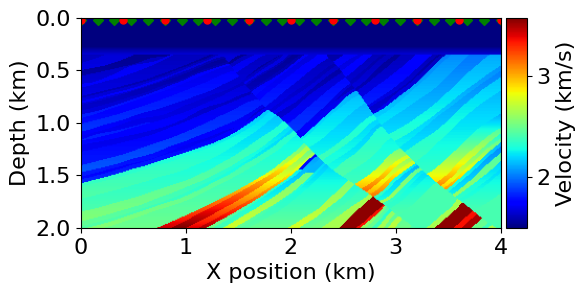

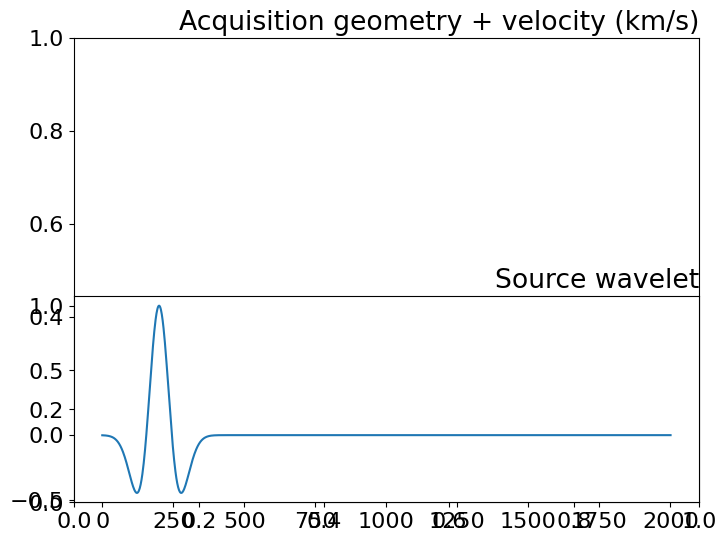

In [95]:
#set source number = 11, and receiver number = 101
nsrc=11; nrcv=101;

#set 11 source locations
src_loc = np.empty((nsrc, 2), dtype=np.float32)
src_loc[:, 0] = np.linspace(0., model.domain_size[0], num=nsrc)
src_loc[:, 1] = 20.

#set 101 receiver locations
rcv_loc = np.empty((nrcv, 2), dtype=np.float32)
rcv_loc[:, 0] = np.linspace(0., model.domain_size[0], num=nrcv)
rcv_loc[:, 1] = 20.

t0 = 0.     # Shot records starts at 0.0
tn = 2000.  # Shot records last 4.0 second (4000 ms)
f0 = 0.005  # Source peak frequency is 5Hz (0.005 kHz)
geom_all = AcquisitionGeometry(model, rcv_loc, src_loc, t0, tn, f0=f0, src_type='Ricker')

# Plot acquisition geometry overlaid with true Vp, and source wavelet
from examples.seismic.plotting import plot_velocity
fig = plt.gcf()
fig.set_size_inches(6, 6)
plt.subplot(2,1,1); plot_velocity(model, source=src_loc, receiver=rcv_loc[::4]); # Plot every one in four receivers.
plt.title('Acquisition geometry + velocity (km/s)', loc='right')
plt.subplot(2,1,2); plt.plot(geom_all.src.time_values, geom_all.src.data[:, 0])
plt.title('Source wavelet', loc='right')
plt.tight_layout(); plt.show()

## Forward model true shot records with the true velocity model

We pick a specific source number and run forward modeling for demonstration. In this case `isrc=3`, but it can be any number between 1 and 11. For this particular source, we run forward modeling twice, one with original/true Vp ("model") and the other with smooth/initial Vp ("model0"). The forward modeling outputs modeled shot data "record" and "record0", respectively. We plot four figures: acquisition geometry with this particular source, shot record from original/ture Vp, shot record from smooth/initial Vp, and their difference. The shot record difference is used to derive FWI gradient.

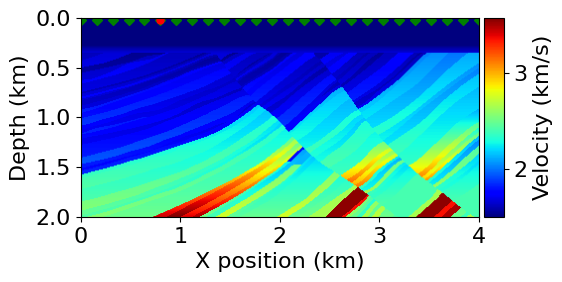

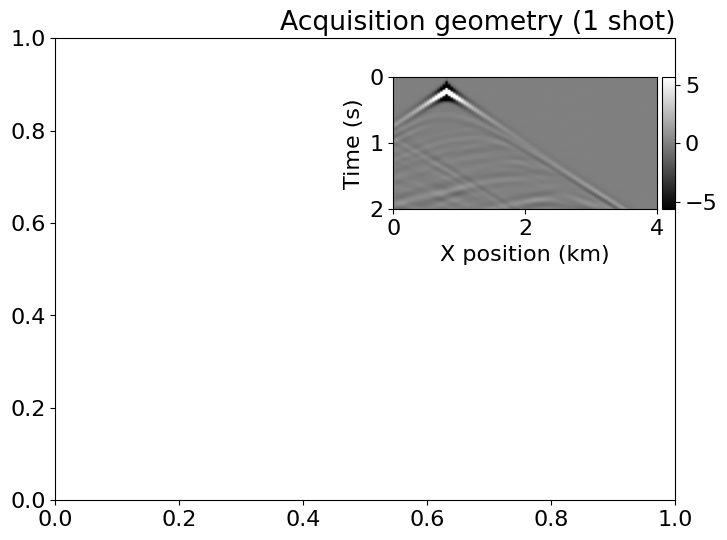

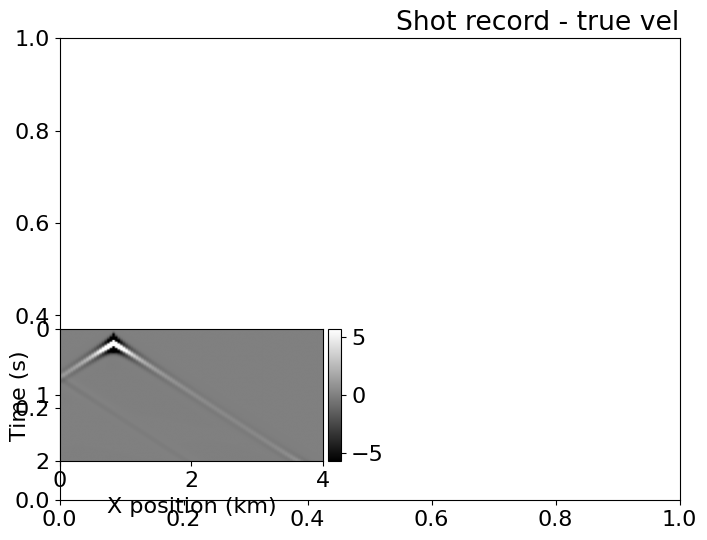

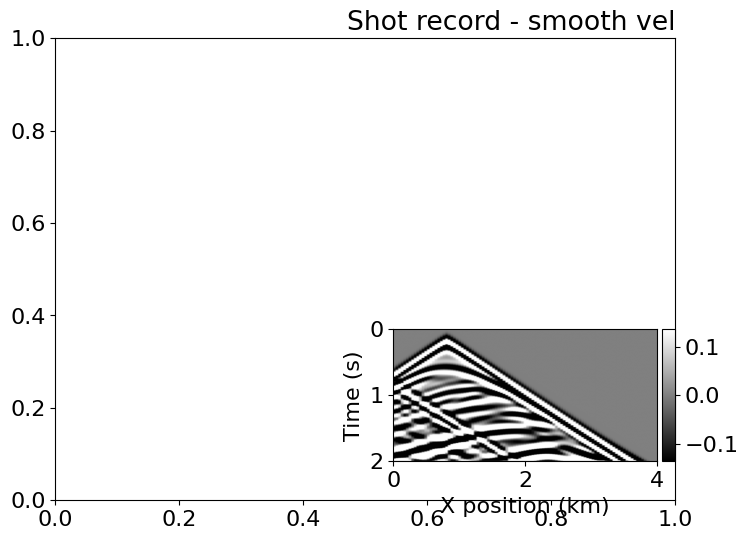

In [96]:
#Pick one source number
isrc = 3
geometry = AcquisitionGeometry(model, rcv_loc, np.copy(src_loc[isrc-1:isrc,:]),
                               t0, tn, f0=f0, src_type='Ricker')
solver = AcousticWaveSolver(model, geometry, space_order=4)

#Define forward modeling of one source
def modeling_1src(vp_in):
    # Create symbols to hold the data
    d_obs = Receiver(name='d_obs', grid=model.grid,
                     time_range=geometry.time_axis,
                     coordinates=geometry.rec_positions)
    d_syn = Receiver(name='d_syn', grid=model.grid,
                     time_range=geometry.time_axis,
                     coordinates=geometry.rec_positions)
    # Generate modeled data from true model
    _, _, _ = solver.forward(vp=model.vp, rec=d_obs)
    # Compute modeled data and full forward wavefield u0 from smooth model
    _, u0, _ = solver.forward(vp=vp_in, save=True, rec=d_syn)
    return d_obs, d_syn

#Genearte modeled shot data of both true and smooth velocity models
record, record0 = modeling_1src(model0.vp)

#Plot acquisition geometry and modeled shot data
from examples.seismic.plotting import plot_velocity, plot_shotrecord
fig = plt.gcf()
fig.set_size_inches(12, 6)
plt.subplot(2,2,1); plot_velocity(model, source=src_loc[isrc-1:isrc,:], receiver=rcv_loc[::4]);
plt.title('Acquisition geometry (1 shot)', loc='right')
plt.subplot(2,2,2); plot_shotrecord(record.data, model, t0, tn)
plt.title('Shot record - true vel', loc='right')
plt.subplot(2,2,3); plot_shotrecord(record0.data, model, t0, tn)
plt.title('Shot record - smooth vel', loc='right')
plt.subplot(2,2,4); plot_shotrecord(record0.data - record.data, model, t0, tn)

## Run 2D FWI with the modeled true shot records and the initial velocity model

### Define FWI Gradient Operator
To compute a single FWI gradient in our workflow, we again use `solver.forward` to compute the entire forward wavefield `u` and a similar pre-defined operator to compute the adjoint wavefield v. The gradient operator provided by our solver utility also computes the correlation between the two wavefields u and v, allowing us to derive the FWI gradient. Those three steps that derive the FWI gradient for a particular source are listed below. This procedure is applied to multiple sources and summed to obtain a FWI gradient image of the subsurface.
* Simulate the forward wavefield u with the background velocity model to obtain the modeled data and save u
* Compute the data residual between the modeled data and true data
* Back-propagate the data residual to derive the wavefield v, and correlate v with the saved wavefield u to compute on the fly the FWI gradient at each time step which will be summed

In [97]:
# This cell contains some functions needed by our FWI algorithm/

# Function to compute the residual between true/observed and modeled/synthetic data
def compute_residual(residual, dobs, dsyn):
    if residual.grid.distributor.is_parallel:
        # Compute the residual via a difference operator for MPI
        diff_eq = Eq(residual, dsyn.subs({dsyn.dimensions[-1]: residual.dimensions[-1]}) -
                               dobs.subs({dobs.dimensions[-1]: residual.dimensions[-1]}))
        Operator(diff_eq)()
    else:
        # A simple data difference is enough in serial
        residual.data[:] = dsyn.data[:] - dobs.data[:]
    return residual



# Function to create FWI gradient kernel
def fwi_gradient(vp_in):
    # Create symbols to hold the gradient, data residual and data
    grad = Function(name="grad", grid=model.grid)
    residual = Receiver(name='residual', grid=model.grid,
                        time_range=geometry.time_axis,
                        coordinates=geometry.rec_positions)
    d_obs = Receiver(name='d_obs', grid=model.grid,
                     time_range=geometry.time_axis,
                     coordinates=geometry.rec_positions)
    d_syn = Receiver(name='d_syn', grid=model.grid,
                     time_range=geometry.time_axis,
                     coordinates=geometry.rec_positions)
    objective = 0.
    for i in range(nsrc):
        # Update source location
        geometry.src_positions[0, :] = src_loc[i, :]
        # Generate true data "d_obs" from true model
        _, _, _ = solver.forward(vp=model.vp, rec=d_obs)
        # Compute smooth/modeled data "d_syn" and full forward wavefield "u0"
        _, u0, _ = solver.forward(vp=vp_in, save=True, rec=d_syn)
        # Compute data "residual" from "d_obs" and "d_syn"
        compute_residual(residual, d_obs, d_syn)
        # Update objective function
        objective += .5 * norm(residual)**2
        # Derive FWI gradient "grad"
        solver.gradient(rec=residual, u=u0, vp=vp_in, grad=grad)
    return objective, grad

# Function to perform the gradient decent update (with box constraints)
from sympy import Min, Max
def update_with_box(vp, alpha, direction, vmin=1.5, vmax=4.7):
    """
    Apply gradient update in-place to vp with box constraint
    """
    update = vp + alpha * direction
    update_eq = Eq(vp, Max(Min(update, vmax), vmin))
    Operator(update_eq)()

In [98]:
# Add simple line search function here

Below we define our FWI iteration loop. The value of alpha is currently undefined and hence this cell wont currently run!

In [99]:
from devito import mmax
import time # For timing puposes only
fwi_start = time.time()

# Run FWI with gradient descent
fwi_iterations = 10
objective = np.zeros((fwi_iterations, 1))
for i in range(0, fwi_iterations):
    # Compute the current FWI objective function and gradient
    objective[i], direction = fwi_gradient(model0.vp)

    alpha =  .16 / mmax(direction)# We need to work out what values alpha can take

    # Update the velocity model in-place and enforce min/max value clips
    update_with_box(model0.vp, alpha, direction)

    # Log the progress of objective function value
    print('Objective value is %11.1f   at iteration %3d' % (objective[i], i+1))


fwi_end = time.time()
print('Total FWI runtime (min):', (fwi_end-fwi_start)/60.0)
print('FWI runtime (min) per iteration:', (fwi_end-fwi_start)/60.0/float(fwi_iterations))

<ipython-input-99-4d7024a7bf3f>:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Objective value is %11.1f   at iteration %3d' % (objective[i], i+1))


Objective value is     68458.7   at iteration   1


<ipython-input-99-4d7024a7bf3f>:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Objective value is %11.1f   at iteration %3d' % (objective[i], i+1))


Objective value is     39363.5   at iteration   2


<ipython-input-99-4d7024a7bf3f>:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Objective value is %11.1f   at iteration %3d' % (objective[i], i+1))


Objective value is     37517.5   at iteration   3


<ipython-input-99-4d7024a7bf3f>:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Objective value is %11.1f   at iteration %3d' % (objective[i], i+1))


Objective value is     90472.7   at iteration   4


<ipython-input-99-4d7024a7bf3f>:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Objective value is %11.1f   at iteration %3d' % (objective[i], i+1))


Objective value is     48897.0   at iteration   5


<ipython-input-99-4d7024a7bf3f>:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Objective value is %11.1f   at iteration %3d' % (objective[i], i+1))


Objective value is     28464.6   at iteration   6


<ipython-input-99-4d7024a7bf3f>:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Objective value is %11.1f   at iteration %3d' % (objective[i], i+1))


Objective value is    102705.5   at iteration   7


<ipython-input-99-4d7024a7bf3f>:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Objective value is %11.1f   at iteration %3d' % (objective[i], i+1))


Objective value is     64691.6   at iteration   8


<ipython-input-99-4d7024a7bf3f>:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Objective value is %11.1f   at iteration %3d' % (objective[i], i+1))


Objective value is     28534.7   at iteration   9
Objective value is     13726.1   at iteration  10
Total FWI runtime (min): 1.9286720991134643
FWI runtime (min) per iteration: 0.19286720991134643


<ipython-input-99-4d7024a7bf3f>:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Objective value is %11.1f   at iteration %3d' % (objective[i], i+1))


Below are some cells to check the result:

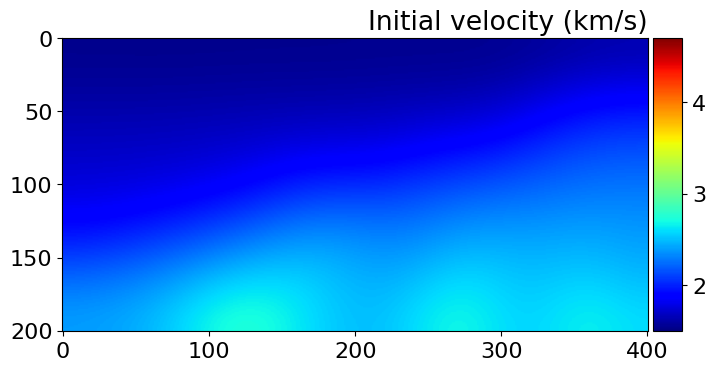

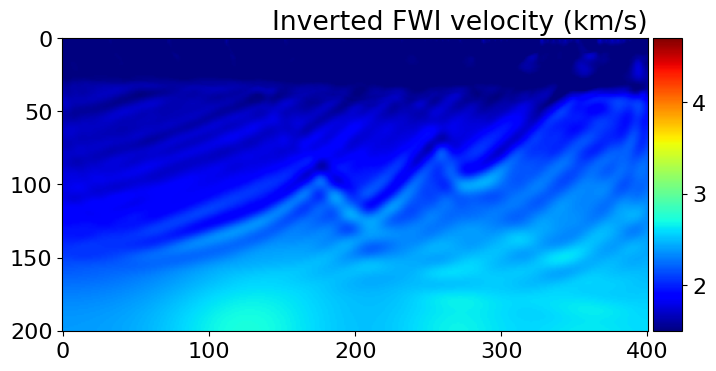

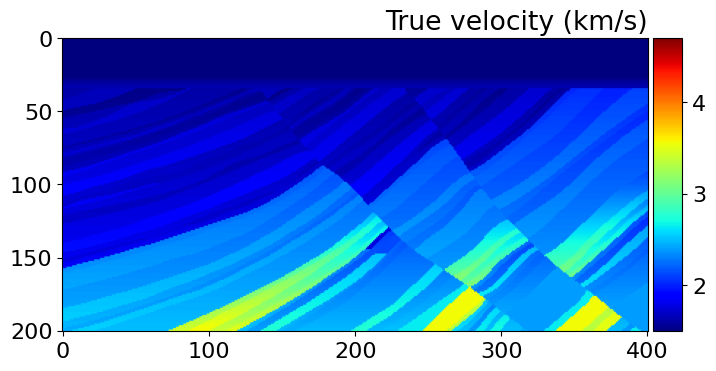

In [100]:
from examples.seismic import plot_image

# Plot initial/smooth velocity model
plt.title('Initial velocity (km/s)', loc='right')
plot_image(v_sm, vmin=1.5, vmax=4.7, cmap="jet")

# Plot inverted velocity model from FWI
plt.title('Inverted FWI velocity (km/s)', loc='right')
plot_image(model0.vp.data[nbl:-nbl, nbl:-nbl], vmin=1.5, vmax=4.7, cmap="jet")

# Plot True velocity model
plt.title('True velocity (km/s)', loc='right')
plot_image(v, vmin=1.5, vmax=4.7, cmap="jet")

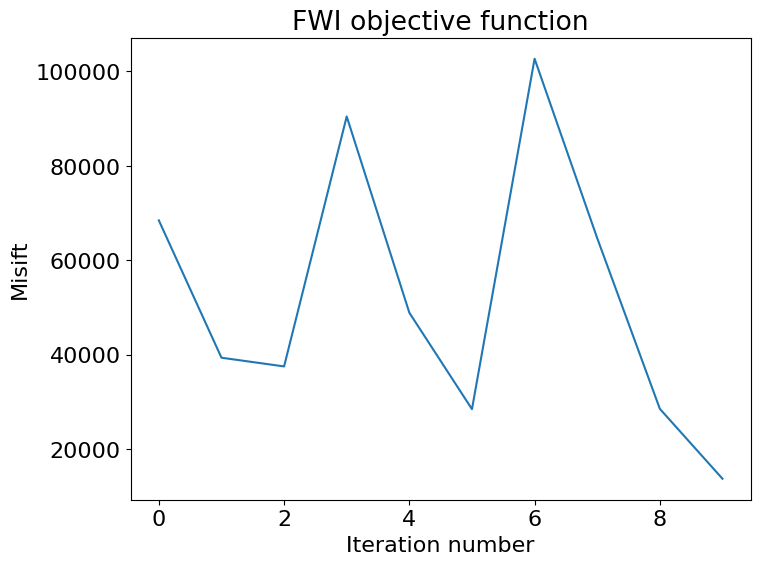

In [101]:
# plot objective function
plt.plot(objective)
plt.xlabel('Iteration number')
plt.ylabel('Misift')
plt.title('FWI objective function')
plt.show()

V = 
[[1.0e+00 1.0e-02 1.0e-04]
 [1.0e+00 1.0e-01 1.0e-02]
 [1.0e+00 5.0e-02 2.5e-03]]

 Our coefficients a = 
[   47656.22222222 -1040756.66666667  7123444.44444444]

The output from np.polyfit(x, y, 2) = 
 [ 7123444.44444445 -1040756.66666667    47656.22222222]

Which agrees with us as long as we reverse the order of our coefficients:
np.flip(a, 0) = 
[ 7123444.44444444 -1040756.66666667    47656.22222222]


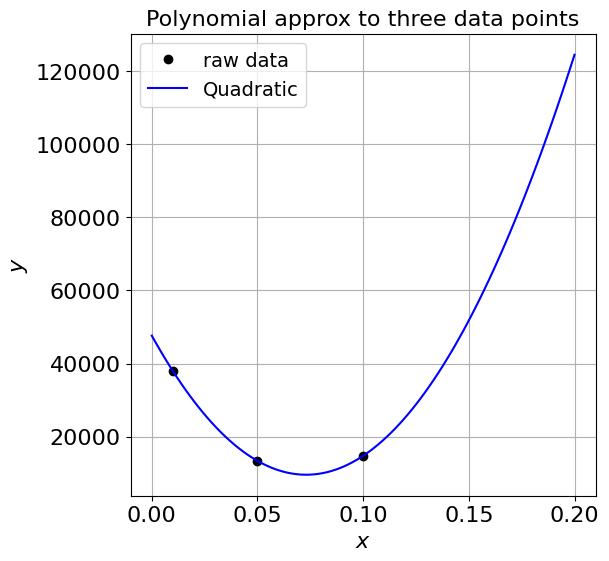

In [108]:
def plot_raw_data(xi, yi, ax):
    """plot x vs y on axes ax,
    add axes labels and turn on grid
    """
    ax.plot(xi, yi, 'ko', label='raw data')
    ax.set_xlabel('$x$', fontsize=16)
    ax.set_ylabel('$y$', fontsize=16)
    ax.grid(True)
# three data point example
xi = [0.01, 0.1, 0.05]
yi = [37961, 14815, 13427]

# use a function to construct the matrix above
# note than numpy already has a function to do this
V = np.vander(xi, 3, increasing=True)    ##square matrix可以不用加这个N+1(3), 但非矩阵就要加N+1(取决于你想拟合多少次方的多项式)

print('V = \n{}'.format(V))

# use a numpy linear algebra solver to solve the system
# uses an LU algorithm - see Lecture 3 for details!
a = np.linalg.solve(V, yi)

# output the coefficients for our quadratic we have computed
print('\n Our coefficients a = \n{}\n'.format(a))

# show that they are the same as is obtained from
# numpy's polyfit function (for a quadratic)
# (which of course they should be, given we argued that this polynomial is unique)
print('The output from np.polyfit(x, y, 2) = \n {}'.format(np.polyfit(xi, yi, 2)))

# Note that the order is reversed because numpy.poly* assumes decreasing
# rather than the increasing powers of x which we have used above

# set up figure
fig = plt.figure(figsize=(6, 6))
ax1 = fig.add_subplot(111)

# plot the raw data
plot_raw_data(xi, yi, ax1)

# x locations at which to evaluate and plot the quadratic polynomial
x = np.linspace(0., .2, 100)

# Set up a polynomial from the coefficients using numpy rather than writing out.
# Use numpy.flip to reverse the coefficients as poly1d assume decreasing rather than
# increasing powers - look at documentation
p2 = np.poly1d(np.flip(a, 0))
print('\nWhich agrees with us as long as we reverse the order of our coefficients:')
print('np.flip(a, 0) = \n{}'.format(np.flip(a, 0)))

# the p2 here is a function so evaluate it at our x locations
y = p2(x)

# and plot
ax1.plot(x, y, 'b', label='Quadratic')

# add a figure title
ax1.set_title('Polynomial approx to three data points', fontsize=16)
# Add a legend
ax1.legend(loc='best', fontsize=14)
# set bounds
# ax1.set_xlim(0, 0.2)
# ax1.set_ylim(0, 50000)

In [103]:
a = 1040756 / (2*7123444)
a

0.07305146218598757

a = 
 [ 5.23263564e+04 -1.68973536e+06  2.57160666e+07 -1.58796743e+08
  3.41247926e+08]

poly_coeffs = 
 [ 3.41247926e+08 -1.58796743e+08  2.57160666e+07 -1.68973536e+06
  5.23263564e+04]

Our _a_ vector = output from np.polyfit (as long as we flip the order)?  True


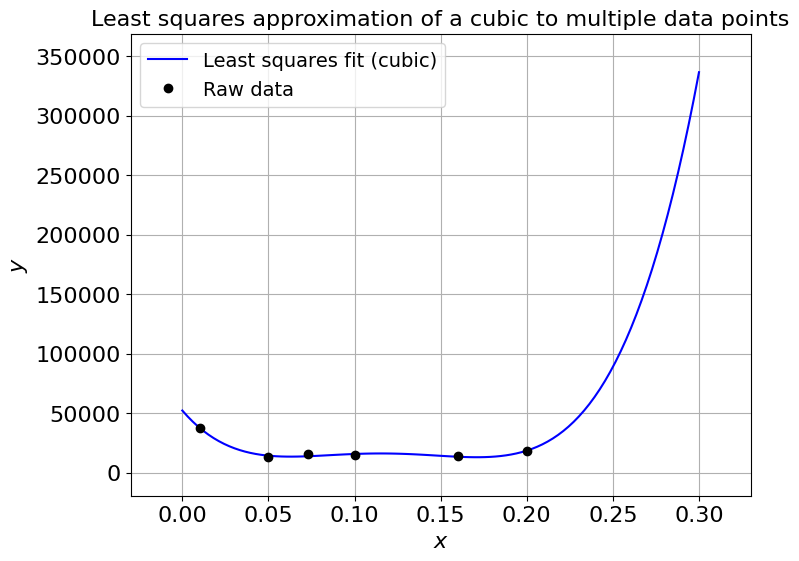

In [110]:
import scipy.linalg as sl
# Our data from Lecture 1:
x = np.array([0.01, 0.1, 0.05, 0.073, 0.2, 0.16])
y = np.array([37961, 14815, 13427, 15664, 18593, 13726])

# Consider a polynomial of degree 3 - so not high enough to go through all the data
N = 4

# Use a numpy function to construct the Vandermonde matrix
V = np.vander(x, N+1, increasing=True)

# Form the matrix A by transposing V and multiplying by V:
A = V.T @ V  # same as A = np.transpose(V) @ V

# Use a function from SciPy's linalg sub-package to find the inverse:
invA = sl.inv(A)

# Form the RHS vector:
rhs = V.T @ y

# Multipy through by the inverse matrix to find a:
a = invA @ rhs
print('a = \n', a)

# Compare against the coefficient that numpy's polyfit gives us
poly_coeffs = np.polyfit(x, y, N)
print('\npoly_coeffs = \n', poly_coeffs)
# they're the same, we just set up our algorithm to return the coefficient in the
# opposite order to polyfit - we need to remember this when we evaluate the polynomial

print('\nOur _a_ vector = output from np.polyfit (as long as we flip the order)? ',
      np.allclose(np.flip(a), poly_coeffs))
# set up figure
fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(111)
ax1.margins(0.1)

xx = np.linspace(0, 0.3, 100)
yy = a[0] + a[1]*xx + a[2] * xx**2 + a[3] * xx**3 + a[4] * xx**4
ax1.plot(xx, yy, 'b', label='Least squares fit (cubic)')

# Overlay raw data
ax1.plot(x, y, 'ko', label='Raw data')
ax1.set_xlabel('$x$', fontsize=16)
ax1.set_ylabel('$y$', fontsize=16)
ax1.set_title('Least squares approximation of a cubic to multiple data points', fontsize=16)
ax1.grid(True)
ax1.legend(loc='best', fontsize=14);